In [1]:
%%capture
try:
    import ttslearn
except ImportError:
    !pip install ttslearn

In [2]:
!pip uninstall --yes ttslearn

Found existing installation: ttslearn 0.2.2
Uninstalling ttslearn-0.2.2:
  Successfully uninstalled ttslearn-0.2.2


ここでドライブをマウント

In [3]:
cd drive/MyDrive/project5/tacotron

/content/drive/MyDrive/project5/tacotron


In [4]:
%%capture
from ttslearn.env import is_colab
from os.path import exists

In [5]:
import time
start_time = time.time()

In [6]:
%pylab inline
%load_ext autoreload
%load_ext tensorboard
%autoreload
import IPython
from IPython.display import Audio
import tensorboard as tb
import os

Populating the interactive namespace from numpy and matplotlib


In [7]:
# 数値演算
import numpy as np
import torch
from torch import nn
# 音声波形の読み込み
from scipy.io import wavfile
# フルコンテキストラベル、質問ファイルの読み込み
from nnmnkwii.io import hts
# 音声分析
import pyworld
# 音声分析、可視化
import librosa
import librosa.display
import pandas as pd
# Pythonで学ぶ音声合成
import ttslearn

In [8]:
# シードの固定
from ttslearn.util import init_seed
init_seed(773)

In [9]:
from ttslearn.notebook import get_cmap, init_plot_style, savefig
cmap = get_cmap()
init_plot_style()

In [10]:
# run.shを利用した学習スクリプトをnotebookから行いたい場合は、True
# google colab の場合は、True とします
# ローカル環境の場合、run.sh をターミナルから実行することを推奨します。
# その場合、このノートブックは可視化・学習済みモデルのテストのために利用します。
run_sh = is_colab()

# 注意: WaveNetを利用した評価データに対する音声生成は時間がかかることに注意
run_stage6 = True

# run.sh経由で実行するスクリプトのtqdm
run_sh_tqdm = "none"

# CUDA
# NOTE: run.shの引数として渡すので、boolではなく文字列で定義しています
cudnn_benchmark = "true"
cudnn_deterministic = "false"

# 特徴抽出時の並列処理のジョブ数
n_jobs = os.cpu_count()//2

# 音響モデル (Tacotron) の設定ファイル名
acoustic_config_name="tacotron2_rf2"
# WaveNetボコーダの設定ファイル名
wavenet_config_name="wavenet_sr16k_mulaw256_30layers"

# Tacotron学習におけるバッチサイズ
tacotron_batch_size = 16
# Tacotron学習のイテレーション数
# 注意: 十分な品質を得るために必要な値: 50k ~ 100k steps
tacotron_max_train_steps = 117600

# WaveNetボコーダの学習におけるバッチサイズ
# 推奨バッチサイズ:  8以上
# 動作確認のため、小さな値に設定しています
wavenet_batch_size = 64
# WavaNetの学習イテレーション数
# 注意: 十分な品質を得るために必要な値: 300k ~ 500k steps
wavenet_max_train_steps = 400000

# 音声生成を行う発話数
# WaveNetの推論は時間がかかるので、ノートブックで表示する5つのみ生成する
num_eval_utts = -1

# ノートブックで利用するテスト用の発話（学習データ、評価データ）
train_utt = "speech_1"
test_utt = "speech_4999"

In [ ]:
!pwd

/content/drive/MyDrive/project5/tacotron


In [ ]:
def ensure_divisible_by(feats, N):
    """Ensure that the number of frames is divisible by N.

    Args:
        feats (np.ndarray): Input features.
        N (int): Target number of frames.

    Returns:
        np.ndarray: Input features with number of frames divisible by N.
    """
    if N == 1:
        return feats
    mod = len(feats) % N
    if mod != 0:
        feats = feats[: len(feats) - mod]
    return feats

In [ ]:
def collate_fn_tacotron(batch, reduction_factor=1):
    """Collate function for Tacotron.

    Args:
        batch (list): List of tuples of the form (inputs, targets).
        reduction_factor (int, optional): Reduction factor. Defaults to 1.

    Returns:
        tuple: Batch of inputs, input lengths, targets, target lengths and stop flags.
    """
    xs = [x[0] for x in batch]
    ys = [ensure_divisible_by(x[1], reduction_factor) for x in batch]
    in_lens = [len(x) for x in xs]
    out_lens = [len(y) for y in ys]
    in_max_len = max(in_lens)
    out_max_len = max(out_lens)
    x_batch = torch.stack([torch.from_numpy(pad_1d(x, in_max_len)) for x in xs])
    y_batch = torch.stack([torch.from_numpy(pad_2d(y, out_max_len)) for y in ys])
    il_batch = torch.tensor(in_lens, dtype=torch.long)
    ol_batch = torch.tensor(out_lens, dtype=torch.long)
    stop_flags = torch.zeros(y_batch.shape[0], y_batch.shape[1])
    for idx, out_len in enumerate(out_lens):
        stop_flags[idx, out_len - 1 :] = 1.0

    #追加
    energys = [x[2] for x in batch]
    pitchs = [x[3] for x in batch]
    exs = [x[4] for x in batch]
    energy_lens = [len(energy) for energy in energys]
    pitch_lens = [len(pitch) for pitch in pitchs]
    ex_lens = [len(ex) for ex in exs]
    energy_max_len = max(energy_lens)
    pitch_max_len = max(pitch_lens)
    ex_max_len = max(ex_lens)
    energy_batch = torch.stack([torch.from_numpy(pad_1d(energy, energy_max_len)) for energy in energys])
    pitch_batch = torch.stack([torch.from_numpy(pad_1d(pitch, pitch_max_len)) for pitch in pitchs])
    ex_batch = torch.stack([torch.from_numpy(pad_1d(ex, ex_max_len)) for ex in exs])
    el_batch = torch.tensor(energy_lens, dtype=torch.long)
    pl_batch = torch.tensor(pitch_lens, dtype=torch.long)
    exl_batch = torch.tensor(ex_lens, dtype=torch.long)


    return x_batch, il_batch, y_batch, ol_batch, stop_flags, energy_batch, el_batch, pitch_batch, pl_batch, ex_batch, exl_batch


In [ ]:
from pathlib import Path
from ttslearn.train_util import Dataset, collate_fn_tacotron
from functools import partial

in_paths = sorted(Path("./dump/jsut_sr16000/norm/dev/in_tacotron/").glob("*.npy"))
out_paths = sorted(Path("./dump/jsut_sr16000/norm/dev/out_tacotron/").glob("*.npy"))
energy_paths = sorted(Path("./dump2/dev/energy/").glob("*.npy"))
pitch_paths = sorted(Path("./dump2/dev/pitch/").glob("*.npy"))
ex_paths = sorted(Path("./dump2/dev/ex/").glob("*.npy"))

dataset = Dataset(in_paths, out_paths, energy_paths, pitch_paths, ex_paths)
collate_fn = partial(collate_fn_tacotron, reduction_factor=1)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, collate_fn=collate_fn, num_workers=0)

in_feats, in_lens, out_feats, out_lens, stop_flags, energy_feats, energy_lens, pitch_feats, pitch_lens, ex_feats, ex_lens = next(iter(data_loader))
print("入力特徴量のサイズ:", tuple(in_feats.shape))
print("出力特徴量のサイズ:", tuple(out_feats.shape))
print("stop flags のサイズ:", tuple(stop_flags.shape))
print("エネルギーのサイズ:", tuple(energy_feats.shape))
print("周波数のサイズ:", tuple(pitch_feats.shape))
print("その他 のサイズ:", tuple(ex_feats.shape))

入力特徴量のサイズ: (8, 139)
出力特徴量のサイズ: (8, 756, 80)
stop flags のサイズ: (8, 756)
エネルギーのサイズ: (8, 67)
周波数のサイズ: (8, 67)
その他 のサイズ: (8, 4)


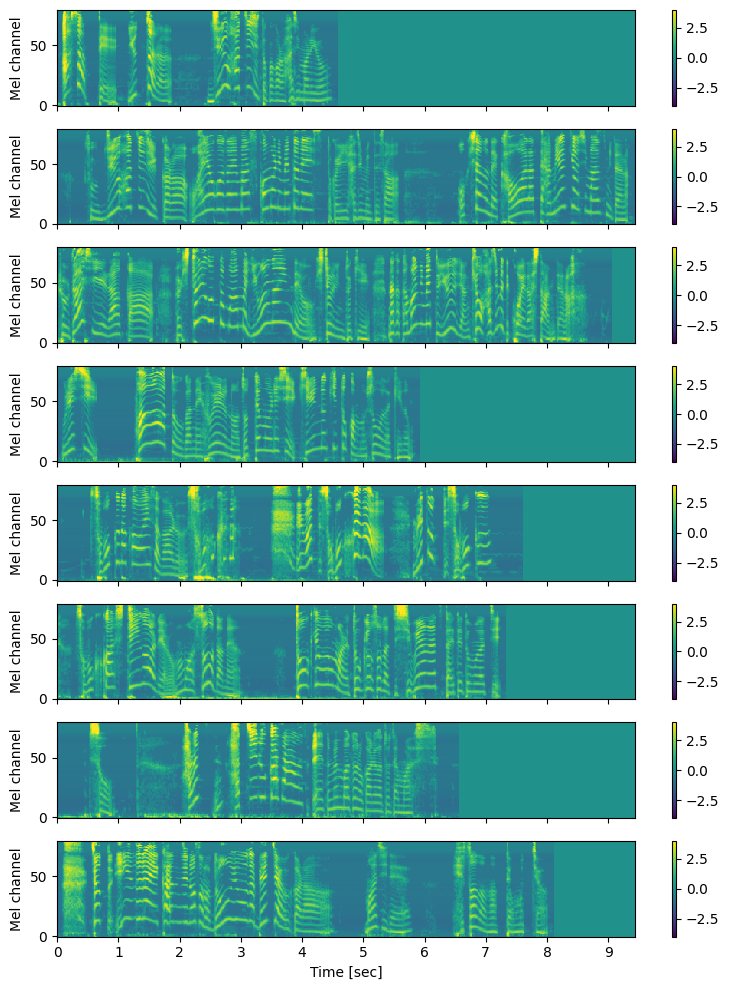

In [ ]:
sr = 16000

fig, ax = plt.subplots(len(out_feats), 1, figsize=(8,10), sharex=True, sharey=True)
for n in range(len(in_feats)):
    x = out_feats[n].data.numpy()
    hop_length = int(sr * 0.0125)
    mesh = librosa.display.specshow(x.T, sr=sr, x_axis="time", y_axis="frames", hop_length=hop_length, cmap=cmap, ax=ax[n])
    fig.colorbar(mesh, ax=ax[n])
    mesh.set_clim(-4, 4)
    # あとで付け直すので、ここではラベルを削除します
    ax[n].set_xlabel("")

ax[-1].set_xlabel("Time [sec]")
for a in ax:
    a.set_ylabel("Mel channel")

plt.tight_layout()
savefig("fig/e2etts_impl_minibatch")

In [ ]:
from ttslearn.tacotron import Tacotron2 as Tacotron
from torch import optim

# 動作確認用：層の数を減らした小さなTacotron
model = Tacotron(
    embed_dim=32, encoder_conv_layers=1, encoder_conv_channels=32, encoder_hidden_dim=32,
    decoder_hidden_dim=32, postnet_channels=32, postnet_layers=1)

# lr は学習率を表します
optimizer = optim.Adam(model.parameters(), lr=0.001)

# gamma は学習率の減衰係数を表します
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=100000)

In [ ]:
from ttslearn.tacotron import Tacotron2 as Tacotron
from torch import optim

# 動作確認用：普通のTacotron
model = Tacotron(
    embed_dim=512, encoder_conv_layers=3, encoder_conv_channels=512, encoder_hidden_dim=512,
    decoder_hidden_dim=1024, postnet_channels=512, postnet_layers=5)

# lr は学習率を表します
optimizer = optim.Adam(model.parameters(), lr=0.001)

# gamma は学習率の減衰係数を表します
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=100000)

In [ ]:
from ttslearn.util import make_non_pad_mask
from tqdm import tqdm

# DataLoader を用いたミニバッチの作成: ミニバッチ毎に処理する
for in_feats, in_lens, out_feats, out_lens, stop_flags, energy_feats, energy_lens, pitch_feats, pitch_lens, ex_feats, ex_lens in tqdm(data_loader):
    in_lens, indices = torch.sort(in_lens, dim=0, descending=True)
    in_feats, out_feats, out_lens = in_feats[indices], out_feats[indices], out_lens[indices]
    energy_feats = energy_feats[indices]
    energy_lens = energy_lens[indices]
    pitch_feats = pitch_feats[indices]
    pitch_lens = pitch_lens[indices]
    ex_feats = ex_feats[indices]
    ex_lens = ex_lens[indices]

    print(in_lens)
    print(in_feats)
    print(out_lens)
    print(out_feats)
    print(energy_lens)
    print(energy_feats)
    print(pitch_lens)
    print(pitch_feats)
    print(ex_lens)
    print(ex_feats)

    # 順伝搬の計算
    outs, outs_fine, logits, _, _2 = model(in_feats, in_lens, energy_feats, energy_lens, pitch_feats, pitch_lens, ex_feats, ex_lens, out_feats)

    # ゼロパディグした部分を損失関数のの計算から除外するためにマスクを適用します
    # Mask (B x T x 1)
    mask = make_non_pad_mask(out_lens).unsqueeze(-1)
    out_feats = out_feats.masked_select(mask)
    outs = outs.masked_select(mask)
    outs_fine = outs_fine.masked_select(mask)
    stop_flags = stop_flags.masked_select(mask.squeeze(-1))
    logits = logits.masked_select(mask.squeeze(-1))

    # 損失の計算
    decoder_out_loss = nn.MSELoss()(outs, out_feats)
    postnet_out_loss = nn.MSELoss()(outs_fine, out_feats)
    stop_token_loss = nn.BCEWithLogitsLoss()(logits, stop_flags)

    # 損失の合計
    loss = decoder_out_loss + postnet_out_loss + stop_token_loss

    # 損失の値を出力
    print(f"decoder_out_loss: {decoder_out_loss:.2f}, postnet_out_loss: {postnet_out_loss:.2f}, stop_token_loss: {stop_token_loss:.2f}")
    # optimizer に蓄積された勾配をリセット
    optimizer.zero_grad()
    # 誤差の逆伝播
    loss.backward()
    # パラメータの更新
    optimizer.step()
    # 学習率スケジューラの更新
    lr_scheduler.step()

Output hidden; open in https://colab.research.google.com to view.

In [11]:
!chmod +x run.sh

In [ ]:
if run_sh:
    ! ./run.sh --stage 3 --stop-stage 3 --acoustic-model $acoustic_config_name \
        --tqdm $run_sh_tqdm --tacotron-train-max-train-steps $tacotron_max_train_steps \
        --tacotron-data-batch-size $tacotron_batch_size \
        --cudnn-benchmark $cudnn_benchmark --cudnn-deterministic $cudnn_deterministic

stage 3: Training Tacotron
+ python train_tacotron.py model=tacotron2_rf2 tqdm=none data.train.utt_list=data/train.list data.train.in_dir=dump/jsut_sr16000/norm/train/in_tacotron/ data.train.out_dir=dump/jsut_sr16000/norm/train/out_tacotron/ data.train.energy_dir=dump2/train/energy/ data.train.pitch_dir=dump2/train/pitch/ data.train.ex_dir=dump2/train/ex/ data.dev.utt_list=data/dev.list data.dev.in_dir=dump/jsut_sr16000/norm/dev/in_tacotron/ data.dev.out_dir=dump/jsut_sr16000/norm/dev/out_tacotron/ data.dev.energy_dir=dump2/dev/energy/ data.dev.pitch_dir=dump2/dev/pitch/ data.dev.ex_dir=dump2/dev/ex/ train.out_dir=exp/jsut_sr16000/tacotron2_rf2 train.log_dir=tensorboard/jsut_sr16000_tacotron2_rf2 train.max_train_steps=117600 data.batch_size=16 cudnn.benchmark=true cudnn.deterministic=false


In [ ]:
!pwd

/content/drive/MyDrive/project5/tacotron


In [ ]:
if run_sh:
    ! ./run.sh --stage 3 --stop-stage 3 --acoustic-model $acoustic_config_name \
        --tqdm $run_sh_tqdm --tacotron-train-max-train-steps $tacotron_max_train_steps \
        --tacotron-data-batch-size $tacotron_batch_size \
        --cudnn-benchmark $cudnn_benchmark --cudnn-deterministic $cudnn_deterministic

stage 3: Training Tacotron
+ python train_tacotron.py model=tacotron2_rf2 tqdm=none data.train.utt_list=data/train.list data.train.in_dir=dump/jsut_sr16000/norm/train/in_tacotron/ data.train.out_dir=dump/jsut_sr16000/norm/train/out_tacotron/ data.train.energy_dir=dump2/train/energy/ data.train.pitch_dir=dump2/train/pitch/ data.train.ex_dir=dump2/train/ex/ data.dev.utt_list=data/dev.list data.dev.in_dir=dump/jsut_sr16000/norm/dev/in_tacotron/ data.dev.out_dir=dump/jsut_sr16000/norm/dev/out_tacotron/ data.dev.energy_dir=dump2/dev/energy/ data.dev.pitch_dir=dump2/dev/pitch/ data.dev.ex_dir=dump2/dev/ex/ train.out_dir=exp/jsut_sr16000/tacotron2_rf2 train.log_dir=tensorboard/jsut_sr16000_tacotron2_rf2 train.max_train_steps=117600 data.batch_size=8 cudnn.benchmark=true cudnn.deterministic=false
2024-01-20 10:12:32.893471: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been

In [ ]:
import torch
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MyModel, self).__init__()
        self.W = nn.Parameter(torch.rand(output_dim, input_dim))

    def forward(self, x):
        # Wを使用して入力xを変換
        transformed_x = torch.matmul(self.W, x)
        return transformed_x

# モデルのインスタンス化
input_dim = 10
output_dim = 5
model = MyModel(input_dim, output_dim)

# 例として、ランダムな入力テンソルを生成
input_tensor = torch.rand(input_dim,input_dim)

# モデルに入力して変換を得る
output_tensor = model(input_tensor)

# Wは学習可能なパラメータとして扱われます
print("W (learnable parameter):", model.W)
print("Output after transformation:", output_tensor)

W (learnable parameter): Parameter containing:
tensor([[0.7329, 0.0368, 0.0664, 0.4922, 0.6021, 0.8549, 0.6167, 0.4723, 0.0155,
         0.9392],
        [0.5874, 0.5241, 0.1031, 0.9285, 0.8040, 0.5531, 0.1857, 0.6293, 0.7274,
         0.9300],
        [0.6511, 0.8447, 0.2437, 0.4965, 0.2013, 0.4435, 0.8128, 0.2413, 0.8982,
         0.9097],
        [0.3501, 0.0599, 0.8263, 0.9000, 0.9370, 0.8127, 0.9671, 0.1429, 0.5288,
         0.2609],
        [0.9469, 0.4753, 0.4335, 0.8209, 0.2222, 0.9827, 0.8946, 0.7846, 0.3628,
         0.1563]], requires_grad=True)
Output after transformation: tensor([[1.7996, 1.3908, 2.3764, 2.5694, 3.1765, 3.0231, 2.0109, 2.1796, 2.1363,
         2.9328],
        [1.9946, 2.0939, 2.6944, 3.1091, 4.2605, 3.4831, 2.3785, 2.2501, 2.8262,
         3.4809],
        [1.9219, 2.2628, 2.5357, 3.0408, 4.0307, 3.0962, 2.5545, 2.1679, 2.4509,
         3.0790],
        [2.6058, 1.8390, 2.6330, 3.4034, 3.9842, 3.3760, 2.7444, 2.6317, 3.0094,
         3.0668],
        [2.4